## This notebook will hold model iterations with the balanced dataset and images of xrays without the medical equipment present.

In [2]:
%load_ext autoreload
%autoreload 2

import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#import tensorflow_addons as tfa
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)
#warnings.filterwarnings('ignore', category=BadKey)

In [4]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.python.keras import datasets, layers, models, regularizers



from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.preprocessing import LabelEncoder

import glob
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.models import load_model

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers

import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    '''takes in true values and predicted values.
    The function then prints out a classifcation report
    as well as a confusion matrix using seaborn's heatmap.'''
    cm = confusion_matrix(y, y_hat)
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    accuracy = accuracy_score(y,y_hat)
    print(classification_report(y, y_hat, target_names=['NORMAL', 'PNEUMONIA']))
    print('Accurancy: ', accuracy)
    sns.heatmap(cm,  cmap= 'Greens', annot=True, fmt='d')
    plt.xlabel('predicted')
    plt.ylabel('actual')
    plt.title(title)
    plt.show()

In [6]:
def show_img(train_images, train_labels):
    plt.figure(figsize=(12,12))
    for i in range(25):
        ax = plt.subplot(5,5,i+1)
        plt.imshow(train_images[i])
        if train_labels[i]:
            plt.title('PNEUMONIA')
        else:
            plt.title('NORMAL')
        plt.axis('off')

In [7]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

In [8]:
image_size=100
batch_size=32

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
train_data = train_datagen.flow_from_directory('../data/chest_xray2/train_2/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
val_data = val_datagen.flow_from_directory('../data/chest_xray2/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary',
                                               color_mode='grayscale')
test_data = test_datagen.flow_from_directory('../data/chest_xray2/test_2/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary',
                                             color_mode='grayscale')

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


In [8]:
first_batch = test_data.next()
data_list = first_batch[0]
batch_index = 0
class_list = first_batch[1]
while batch_index <= test_data.batch_index:
    data = test_data.next()
    #print(data[0].shape)
    data_list=np.concatenate((data_list, data[0]))
    class_list=np.concatenate((class_list, data[1]))
    batch_index = batch_index + 1
data_array = np.asarray(data_list)
data_array.shape

(427, 100, 100, 1)

In [9]:
model2 = Sequential()
model2.add(Convolution2D(32, (3,3), input_shape=(100,100,1), activation='relu'))
#Batch Normalization Layer
model2.add(BatchNormalization())
model2.add(MaxPooling2D(2,2))
model2.add(Flatten())
model2.add(Dense(units=110, activation='relu'))
model2.add(Dense(units=1, activation='sigmoid'))
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=[
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ])

history2 = model2.fit(train_data, epochs=15,  validation_data=(val_data))

Epoch 1/15
81/81 [==============================] - 37s 460ms/step - loss: 1.0133 - accuracy: 0.8808 - precision: 0.8946 - recall: 0.8921 - val_loss: 0.5429 - val_accuracy: 0.6836 - val_precision: 0.6628 - val_recall: 1.0000
Epoch 2/15
81/81 [==============================] - 37s 456ms/step - loss: 0.0842 - accuracy: 0.9700 - precision: 0.9729 - recall: 0.9735 - val_loss: 0.4065 - val_accuracy: 0.8782 - val_precision: 0.8446 - val_recall: 0.9854
Epoch 3/15
81/81 [==============================] - 37s 456ms/step - loss: 0.0369 - accuracy: 0.9860 - precision: 0.9888 - recall: 0.9861 - val_loss: 0.3634 - val_accuracy: 0.8273 - val_precision: 0.7852 - val_recall: 0.9942
Epoch 4/15
81/81 [==============================] - 37s 453ms/step - loss: 0.0128 - accuracy: 0.9973 - precision: 0.9972 - recall: 0.9979 - val_loss: 0.1954 - val_accuracy: 0.9345 - val_precision: 0.9250 - val_recall: 0.9737
Epoch 5/15
81/81 [==============================] - 37s 455ms/step - loss: 0.0058 - accuracy: 0.9988

              precision    recall  f1-score   support

      NORMAL       0.97      0.41      0.58       232
   PNEUMONIA       0.59      0.98      0.73       195

    accuracy                           0.67       427
   macro avg       0.78      0.70      0.66       427
weighted avg       0.79      0.67      0.65       427

Accurancy:  0.6744730679156908


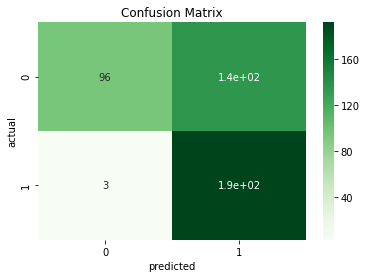

14/14 [==============================] - 3s 215ms/step - loss: 3.7058 - accuracy: 0.6745 - precision: 0.5854 - recall: 0.9846


[('loss', 3.7058138847351074),
 ('accuracy', 0.6744730472564697),
 ('precision', 0.5853658318519592),
 ('recall', 0.9846153855323792)]

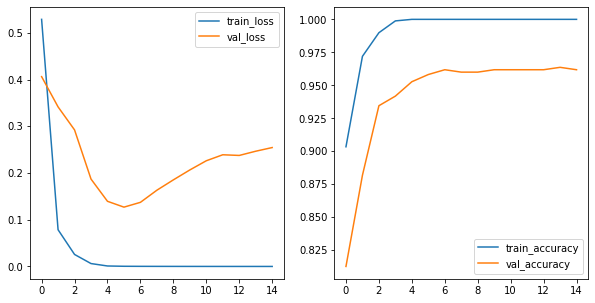

In [25]:
preds2 = model2.predict_classes(data_array)
evaluation(class_list, preds2)

train_loss = history2.history['loss']
train_acc = history2.history['accuracy']
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(history2.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(history2.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(history2.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(history2.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = model2.evaluate_generator(test_data, steps=len(test_data), verbose=1)
list(zip(model2.metrics_names, acc))

### Pre-trained Models
- ResNet-50
- MobileNetV2
- InceptionV3
- Inception-ResNet-V3
#### Model Parameters
- Global Average Pooling 2D layer
- Dense layer with 50 nodes and relu activation
- batch size of 32
- image dimension 100x100
 For the transfer models I need to reload the data generators to be RGB scale and not grey scale

In [15]:


train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
transfer_train_data = train_datagen.flow_from_directory('../data/chest_xray2/train_2/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_val_data = val_datagen.flow_from_directory('../data/chest_xray2/val/',
                                               target_size=(100,100),
                                               batch_size=32,
                                               class_mode='binary')
transfer_test_data = test_datagen.flow_from_directory('../data/chest_xray2/test_2/',
                                             target_size=(100,100),
                                             batch_size=32,
                                             class_mode='binary')

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


In [16]:
transfer_first_batch = transfer_test_data.next()
transfer_data_list = transfer_first_batch[0]
batch_index = 0
transfer_class_list = transfer_first_batch[1]
while batch_index <= transfer_test_data.batch_index:
    transfer_data = transfer_test_data.next()
    #print(data[0].shape)
    transfer_data_list=np.concatenate((transfer_data_list, transfer_data[0]))
    transfer_class_list=np.concatenate((transfer_class_list, transfer_data[1]))
    batch_index = batch_index + 1
transfer_data_array = np.asarray(transfer_data_list)
transfer_data_array.shape

(427, 100, 100, 3)

### ResNet-50

In [17]:
image_size=100
batch_size=32

In [58]:
input_shape = Input(shape=(100,100,3))

base_model_resnet50 = ResNet50(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_resnet50.trainable=False

base_model_resnet50.layers[-1].get_config()

{'name': 'conv5_block3_out',
 'trainable': False,
 'dtype': 'float32',
 'activation': 'relu'}

In [66]:
res50 = Sequential([base_model_resnet50,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

res50.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

res_history = res50.fit(transfer_train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/15
80/80 [==============================] - 35s 442ms/step - loss: 0.6031 - accuracy: 0.6826 - precision: 0.6927 - recall: 0.7952 - val_loss: 0.4962 - val_accuracy: 0.8000 - val_precision: 0.7900 - val_recall: 0.9240
Epoch 2/15
80/80 [==============================] - 37s 461ms/step - loss: 0.5051 - accuracy: 0.7646 - precision: 0.7695 - recall: 0.8265 - val_loss: 0.4495 - val_accuracy: 0.8327 - val_precision: 0.8834 - val_recall: 0.8421
Epoch 3/15
80/80 [==============================] - 41s 512ms/step - loss: 0.4608 - accuracy: 0.7953 - precision: 0.7984 - recall: 0.8475 - val_loss: 0.3939 - val_accuracy: 0.8273 - val_precision: 0.8065 - val_recall: 0.9503
Epoch 4/15
80/80 [==============================] - 40s 497ms/step - loss: 0.4266 - accuracy: 0.8048 - precision: 0.8105 - recall: 0.8499 - val_loss: 0.3554 - val_accuracy: 0.8600 - val_precision: 0.8478 - val_recall: 0.9444
Epoch 5/15
80/80 [==============================] - 40s 496ms/step - loss: 0.4077 - accuracy: 0.8178

In [ ]:
res50_preds = res50.predict_classes(transfer_data_array)
evaluation(transfer_class_list, res50_preds)

train_loss = res_history.history['loss']
train_acc = res_history.history['accuracy']
val_loss = res_history.history['val_loss']
val_acc = res_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(res_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(res_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(res_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(res_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = res50.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(res50.metrics_names, acc))

### MobileNetV2

In [47]:
base_model_mobilenet = MobileNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_mobilenet.trainable=False

base_model_mobilenet.layers[-1].get_config()

{'name': 'out_relu',
 'trainable': False,
 'dtype': 'float32',
 'max_value': array(6., dtype=float32),
 'negative_slope': array(0., dtype=float32),
 'threshold': array(0., dtype=float32)}

In [48]:
mobilenet = Sequential([base_model_mobilenet,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

mobilenet.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

mobilenet_history = mobilenet.fit(transfer_train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/10
80/80 [==============================] - 21s 269ms/step - loss: 0.2962 - accuracy: 0.8726 - precision: 0.8206 - recall: 0.8984 - val_loss: 0.2086 - val_accuracy: 0.9164 - val_precision: 0.9157 - val_recall: 0.9532
Epoch 2/10
80/80 [==============================] - 21s 266ms/step - loss: 0.1862 - accuracy: 0.9263 - precision: 0.9358 - recall: 0.9325 - val_loss: 0.1806 - val_accuracy: 0.9255 - val_precision: 0.9574 - val_recall: 0.9211
Epoch 3/10
80/80 [==============================] - 22s 270ms/step - loss: 0.1431 - accuracy: 0.9476 - precision: 0.9591 - recall: 0.9462 - val_loss: 0.2209 - val_accuracy: 0.9127 - val_precision: 0.8910 - val_recall: 0.9795
Epoch 4/10
80/80 [==============================] - 23s 284ms/step - loss: 0.1407 - accuracy: 0.9401 - precision: 0.9450 - recall: 0.9476 - val_loss: 0.1848 - val_accuracy: 0.9309 - val_precision: 0.9497 - val_recall: 0.9386
Epoch 5/10
80/80 [==============================] - 23s 292ms/step - loss: 0.1130 - accuracy: 0.9543

              precision    recall  f1-score   support

      NORMAL       0.99      0.37      0.53       197
   PNEUMONIA       0.57      0.99      0.72       166

    accuracy                           0.65       363
   macro avg       0.78      0.68      0.63       363
weighted avg       0.80      0.65      0.62       363

Accurancy:  0.6528925619834711


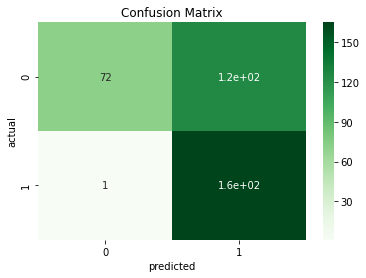

14/14 [==============================] - 5s 362ms/step - loss: 1.7334 - accuracy: 0.6557 - precision: 0.5706 - recall: 0.9949


[('loss', 1.7333515882492065),
 ('accuracy', 0.6557376980781555),
 ('precision', 0.570588231086731),
 ('recall', 0.9948717951774597)]

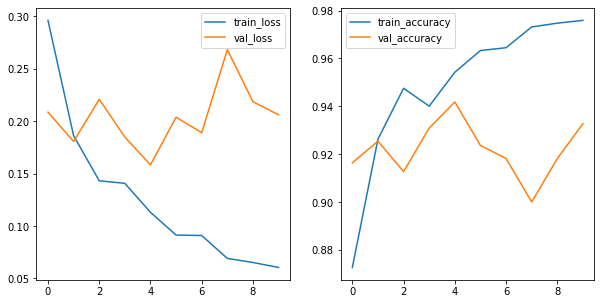

In [49]:
mobilenet_preds = mobilenet.predict_classes(transfer_data_array)
evaluation(transfer_class_list, mobilenet_preds)

train_loss = mobilenet_history.history['loss']
train_acc = mobilenet_history.history['accuracy']
val_loss = mobilenet_history.history['val_loss']
val_acc = mobilenet_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(mobilenet_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(mobilenet_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(mobilenet_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(mobilenet_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = mobilenet.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(mobilenet.metrics_names, acc))

### InceptionV3

In [50]:
input_shape = Input(shape=(100,100,3))

base_model_inception3 = InceptionV3(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_inception3.trainable=False

base_model_inception3.layers[-1].get_config()

{'name': 'mixed10', 'trainable': False, 'dtype': 'float32', 'axis': 3}

In [51]:
inception3 = Sequential([base_model_inception3,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception3.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

inception3_history = inception3.fit(transfer_train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/10
80/80 [==============================] - 18s 230ms/step - loss: 0.3491 - accuracy: 0.8496 - precision: 0.8038 - recall: 0.8907 - val_loss: 0.2334 - val_accuracy: 0.9127 - val_precision: 0.9153 - val_recall: 0.9474
Epoch 2/10
80/80 [==============================] - 17s 216ms/step - loss: 0.2208 - accuracy: 0.9113 - precision: 0.9202 - recall: 0.9208 - val_loss: 0.2730 - val_accuracy: 0.8873 - val_precision: 0.9545 - val_recall: 0.8596
Epoch 3/10
80/80 [==============================] - 18s 219ms/step - loss: 0.1946 - accuracy: 0.9200 - precision: 0.9318 - recall: 0.9246 - val_loss: 0.2682 - val_accuracy: 0.8800 - val_precision: 0.9452 - val_recall: 0.8567
Epoch 4/10
80/80 [==============================] - 20s 245ms/step - loss: 0.1644 - accuracy: 0.9338 - precision: 0.9406 - recall: 0.9406 - val_loss: 0.2529 - val_accuracy: 0.8982 - val_precision: 0.9387 - val_recall: 0.8947
Epoch 5/10
80/80 [==============================] - 20s 247ms/step - loss: 0.1387 - accuracy: 0.9483

              precision    recall  f1-score   support

      NORMAL       0.91      0.51      0.66       197
   PNEUMONIA       0.62      0.94      0.75       166

    accuracy                           0.71       363
   macro avg       0.76      0.73      0.70       363
weighted avg       0.78      0.71      0.70       363

Accurancy:  0.7079889807162535


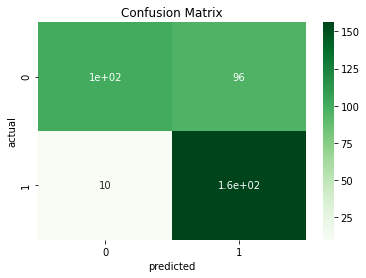

14/14 [==============================] - 5s 351ms/step - loss: 1.0861 - accuracy: 0.7190 - precision: 0.6280 - recall: 0.9436


[('loss', 1.0860596895217896),
 ('accuracy', 0.7189695835113525),
 ('precision', 0.6279863715171814),
 ('recall', 0.9435897469520569)]

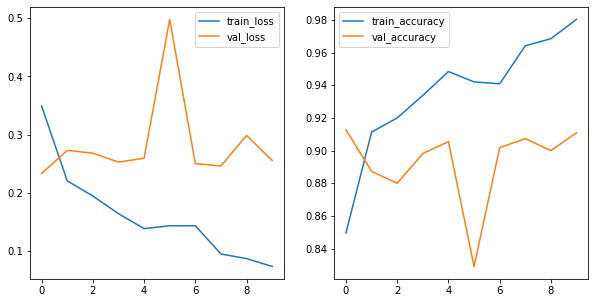

In [52]:
inception3_preds = inception3.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception3_preds)

train_loss = inception3_history.history['loss']
train_acc = inception3_history.history['accuracy']
val_loss = inception3_history.history['val_loss']
val_acc = inception3_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception3_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception3_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception3_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception3_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception3.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception3.metrics_names, acc))

### InceptionResNetV2

In [9]:
input_shape = Input(shape=(100,100,3))

base_model_inception_res = InceptionResNetV2(input_tensor=input_shape, include_top=False, weights='imagenet')

base_model_inception_res.trainable=False

base_model_inception_res.layers[-1].get_config()

{'name': 'conv_7b_ac',
 'trainable': False,
 'dtype': 'float32',
 'activation': 'relu'}

In [15]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/10
80/80 [==============================] - 25s 317ms/step - loss: 0.3214 - accuracy: 0.8726 - precision: 0.8828 - recall: 0.8908 - val_loss: 0.1962 - val_accuracy: 0.9236 - val_precision: 0.9717 - val_recall: 0.9035
Epoch 2/10
80/80 [==============================] - 22s 279ms/step - loss: 0.2124 - accuracy: 0.9129 - precision: 0.9232 - recall: 0.9212 - val_loss: 0.1490 - val_accuracy: 0.9309 - val_precision: 0.9343 - val_recall: 0.9561
Epoch 3/10
80/80 [==============================] - 26s 322ms/step - loss: 0.1853 - accuracy: 0.9211 - precision: 0.9321 - recall: 0.9269 - val_loss: 0.1745 - val_accuracy: 0.9309 - val_precision: 0.9841 - val_recall: 0.9035
Epoch 4/10
80/80 [==============================] - 29s 360ms/step - loss: 0.1791 - accuracy: 0.9278 - precision: 0.9362 - recall: 0.9342 - val_loss: 0.1532 - val_accuracy: 0.9345 - val_precision: 0.9448 - val_recall: 0.9503
Epoch 5/10
80/80 [==============================] - 26s 319ms/step - loss: 0.1644 - accuracy: 0.9341

              precision    recall  f1-score   support

      NORMAL       0.97      0.51      0.67       232
   PNEUMONIA       0.63      0.98      0.77       195

    accuracy                           0.73       427
   macro avg       0.80      0.75      0.72       427
weighted avg       0.81      0.73      0.71       427

Accurancy:  0.7259953161592506


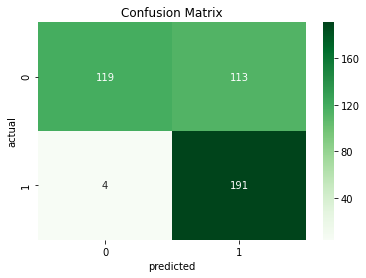

14/14 [==============================] - 5s 365ms/step - loss: 1.1544 - accuracy: 0.7260 - precision: 0.6283 - recall: 0.9795


[('loss', 1.1544396877288818),
 ('accuracy', 0.7259953022003174),
 ('precision', 0.6282894611358643),
 ('recall', 0.9794871807098389)]

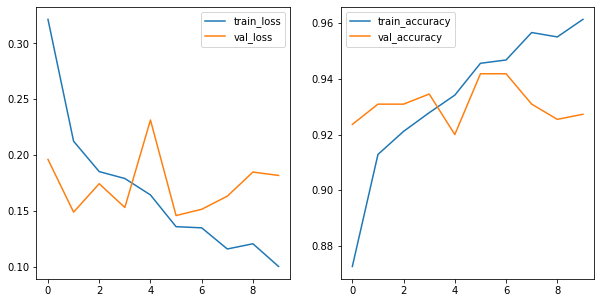

In [17]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

### Trying InceptionResNetV2 with class weights put in

In [10]:
tr_train_files = glob.glob('../data/chest_xray2/train_2/NORMAL/*'),  glob.glob('../data/chest_xray2/train_2/PNEUMONIA/*')


In [11]:
# NORMAL COUNT
count_normal = len(tr_train_files[0])
count_normal

1132

In [12]:
# PNEUMONIA COUNT
count_pneumonia = len(tr_train_files[1])
count_pneumonia

1436

In [13]:
initial_bias = np.log([count_pneumonia/count_normal])
initial_bias

array([0.23787549])

In [14]:
weight_normal = (1 / count_normal) * (count_normal+count_pneumonia) / 2
weight_pneumonia = (1 / count_pneumonia) * (count_normal+count_pneumonia) / 2
class_weight = {0: weight_normal, 1: weight_pneumonia}
class_weight

{0: 1.1342756183745584, 1: 0.8941504178272981}

## Second iteration
- Increasing nodes in the dense layer from 50 to 110

In [18]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(110, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 30

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/30
80/80 [==============================] - 53s 658ms/step - loss: 0.4970 - accuracy: 0.8340 - precision: 0.8700 - recall: 0.8264 - val_loss: 0.1788 - val_accuracy: 0.9255 - val_precision: 0.9388 - val_recall: 0.9415
Epoch 2/30
80/80 [==============================] - 45s 563ms/step - loss: 0.2236 - accuracy: 0.9062 - precision: 0.9253 - recall: 0.9058 - val_loss: 0.1684 - val_accuracy: 0.9291 - val_precision: 0.9292 - val_recall: 0.9591
Epoch 3/30
80/80 [==============================] - 43s 532ms/step - loss: 0.1949 - accuracy: 0.9203 - precision: 0.9371 - recall: 0.9199 - val_loss: 0.1790 - val_accuracy: 0.9291 - val_precision: 0.9633 - val_recall: 0.9211
Epoch 4/30
80/80 [==============================] - 33s 415ms/step - loss: 0.1746 - accuracy: 0.9278 - precision: 0.9407 - recall: 0.9294 - val_loss: 0.1525 - val_accuracy: 0.9364 - val_precision: 0.9666 - val_recall: 0.9298
Epoch 5/30
80/80 [==============================] - 27s 338ms/step - loss: 0.1546 - accuracy: 0.9393

              precision    recall  f1-score   support

      NORMAL       0.95      0.60      0.74       232
   PNEUMONIA       0.67      0.96      0.79       195

    accuracy                           0.77       427
   macro avg       0.81      0.78      0.76       427
weighted avg       0.82      0.77      0.76       427

Accurancy:  0.765807962529274


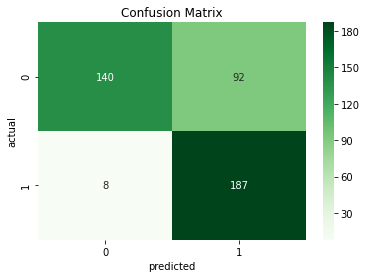

14/14 [==============================] - 10s 725ms/step - loss: 1.7818 - accuracy: 0.7658 - precision: 0.6703 - recall: 0.9590


[('loss', 1.781792402267456),
 ('accuracy', 0.7658079862594604),
 ('precision', 0.6702508926391602),
 ('recall', 0.9589743614196777)]

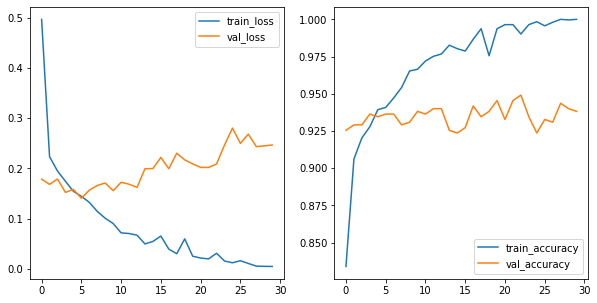

In [19]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

That decreased the performance in the model, I am going to try going back to 50 nodes in the dense layer and decreasing the epochs to from 30 to 15.

In [101]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])

inception_resnet2.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 15

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/15
80/80 [==============================] - 25s 308ms/step - loss: 0.3446 - accuracy: 0.8726 - precision: 0.8640 - recall: 0.8865 - val_loss: 0.2061 - val_accuracy: 0.9200 - val_precision: 0.9627 - val_recall: 0.9064
Epoch 2/15
80/80 [==============================] - 27s 343ms/step - loss: 0.2355 - accuracy: 0.9085 - precision: 0.9280 - recall: 0.9071 - val_loss: 0.3695 - val_accuracy: 0.8618 - val_precision: 0.9926 - val_recall: 0.7836
Epoch 3/15
80/80 [==============================] - 29s 361ms/step - loss: 0.1957 - accuracy: 0.9184 - precision: 0.9341 - recall: 0.9190 - val_loss: 0.1757 - val_accuracy: 0.9291 - val_precision: 0.9522 - val_recall: 0.9327
Epoch 4/15
80/80 [==============================] - 27s 343ms/step - loss: 0.1654 - accuracy: 0.9334 - precision: 0.9471 - recall: 0.9331 - val_loss: 0.1683 - val_accuracy: 0.9309 - val_precision: 0.9720 - val_recall: 0.9152
Epoch 5/15
80/80 [==============================] - 28s 351ms/step - loss: 0.1519 - accuracy: 0.9397

              precision    recall  f1-score   support

      NORMAL       0.94      0.69      0.80       232
   PNEUMONIA       0.72      0.94      0.82       195

    accuracy                           0.81       427
   macro avg       0.83      0.82      0.81       427
weighted avg       0.84      0.81      0.81       427

Accurancy:  0.8079625292740047


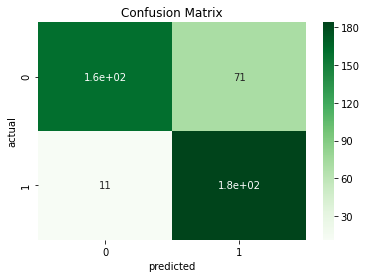

14/14 [==============================] - 6s 410ms/step - loss: 0.8142 - accuracy: 0.8080 - precision: 0.7216 - recall: 0.9436


[('loss', 0.8141981959342957),
 ('accuracy', 0.8079625368118286),
 ('precision', 0.7215686440467834),
 ('recall', 0.9435897469520569)]

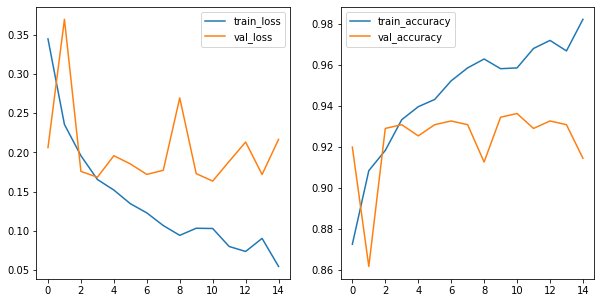

In [102]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

### InceptionResNetV2 with gradients applied to the variables 

# 2 cells below took too long, I will try overnight

In [ ]:
optimizer = tf.keras.optimizers.SGD()
loss_fn = tf.keras.losses.BinaryCrossentropy()

# Iterate over the batches of a dataset.
for x, y in transfer_train_data:
    # Open a GradientTape.
    with tf.GradientTape() as tape:
        # Forward pass.
        logits = inception_resnet2(x)
        # Loss value for this batch.
        loss_value = loss_fn(y, logits)

    # Get gradients of loss wrt the weights.
    gradients = tape.gradient(loss_value, inception_resnet2.trainable_weights)

    # Update the weights of the model.
    optimizer.apply_gradients(zip(gradients, inception_resnet2.trainable_weights))

In [ ]:
grads = tape.gradient(loss, vars)
grads = tf.distribute.get_replica_context().all_reduce('sum', grads)
optimizer.apply_gradients(zip(grads, vars),
                         experimental_aggregate_gradients=False)

### Learning rate decay

In [117]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=1e-2,
                                                            decay_steps=1000,
                                                            decay_rate=0.1)


optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)


In [118]:
inception_resnet2 = Sequential([base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])


inception_resnet2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

inception_resnet2_history = inception_resnet2.fit(transfer_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=transfer_val_data)

Epoch 1/10
80/80 [==============================] - 24s 305ms/step - loss: 0.6344 - accuracy: 0.8718 - precision: 0.8683 - recall: 0.8817 - val_loss: 0.2349 - val_accuracy: 0.9182 - val_precision: 0.9046 - val_recall: 0.9708
Epoch 2/10
80/80 [==============================] - 23s 282ms/step - loss: 0.2578 - accuracy: 0.9132 - precision: 0.9292 - recall: 0.9148 - val_loss: 0.1984 - val_accuracy: 0.9236 - val_precision: 0.9747 - val_recall: 0.9006
Epoch 3/10
80/80 [==============================] - 24s 305ms/step - loss: 0.1859 - accuracy: 0.9219 - precision: 0.9332 - recall: 0.9267 - val_loss: 0.3070 - val_accuracy: 0.8855 - val_precision: 0.9861 - val_recall: 0.8275
Epoch 4/10
80/80 [==============================] - 26s 323ms/step - loss: 0.1558 - accuracy: 0.9381 - precision: 0.9520 - recall: 0.9366 - val_loss: 0.1540 - val_accuracy: 0.9400 - val_precision: 0.9640 - val_recall: 0.9386
Epoch 5/10
80/80 [==============================] - 26s 319ms/step - loss: 0.1421 - accuracy: 0.9460

              precision    recall  f1-score   support

      NORMAL       0.95      0.68      0.79       232
   PNEUMONIA       0.72      0.96      0.82       195

    accuracy                           0.81       427
   macro avg       0.83      0.82      0.81       427
weighted avg       0.84      0.81      0.81       427

Accurancy:  0.8079625292740047


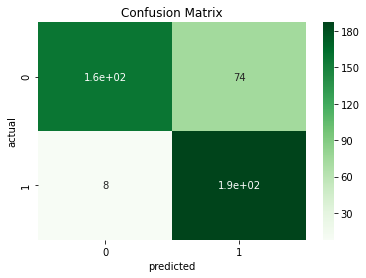

14/14 [==============================] - 5s 373ms/step - loss: 0.7261 - accuracy: 0.8080 - precision: 0.7165 - recall: 0.9590


[('loss', 0.7260624170303345),
 ('accuracy', 0.8079625368118286),
 ('precision', 0.7164750695228577),
 ('recall', 0.9589743614196777)]

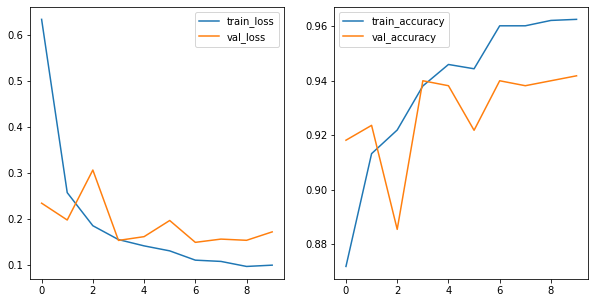

In [119]:
inception_resnet2_preds = inception_resnet2.predict_classes(transfer_data_array)
evaluation(transfer_class_list, inception_resnet2_preds)

train_loss = inception_resnet2_history.history['loss']
train_acc = inception_resnet2_history.history['accuracy']
val_loss = inception_resnet2_history.history['val_loss']
val_acc = inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = inception_resnet2.evaluate_generator(transfer_test_data, steps=len(transfer_test_data), verbose=1)
list(zip(inception_resnet2.metrics_names, acc))

# Changing image size to 299x299 for lime

In [120]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./225)
lime_train_data = train_datagen.flow_from_directory('../data/chest_xray2/train_2/',
                                               target_size=(299,299),
                                               batch_size=32,
                                               class_mode='binary')
lime_val_data = val_datagen.flow_from_directory('../data/chest_xray2/val/',
                                               target_size=(299,299),
                                               batch_size=32,
                                               class_mode='binary')
lime_test_data = test_datagen.flow_from_directory('../data/chest_xray2/test_2/',
                                             target_size=(299,299),
                                             batch_size=32,
                                             class_mode='binary')

Found 2568 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 427 images belonging to 2 classes.


In [122]:
lime_input_shape = Input(shape=(299,299,3))
lime_base_model_inception_res = InceptionResNetV2(input_tensor=lime_input_shape, include_top=False, weights='imagenet')
lime_base_model_inception_res.trainable=False



lime_inception_resnet2 = Sequential([lime_base_model_inception_res,
                    tf.keras.layers.GlobalAveragePooling2D(),
                    tf.keras.layers.Dense(50, activation='relu'),
                    tf.keras.layers.Dense(1, activation='sigmoid')])


lime_inception_resnet2.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=METRICS)

epochs = 10

steps_per_epoch = transfer_train_data.n // batch_size

lime_inception_resnet2_history = lime_inception_resnet2.fit(lime_train_data, class_weight=class_weight,
                  steps_per_epoch = steps_per_epoch,
                  epochs=epochs,
                  workers=4,
                  validation_data=lime_val_data)

Epoch 1/10
80/80 [==============================] - 298s 4s/step - loss: 0.3624 - accuracy: 0.8368 - precision: 0.8511 - recall: 0.8395 - val_loss: 0.2551 - val_accuracy: 0.8982 - val_precision: 0.9735 - val_recall: 0.8596
Epoch 2/10
80/80 [==============================] - 309s 4s/step - loss: 0.1982 - accuracy: 0.9188 - precision: 0.9507 - recall: 0.9008 - val_loss: 0.2322 - val_accuracy: 0.9091 - val_precision: 0.9710 - val_recall: 0.8801
Epoch 3/10
80/80 [==============================] - 307s 4s/step - loss: 0.1761 - accuracy: 0.9271 - precision: 0.9565 - recall: 0.9115 - val_loss: 0.1830 - val_accuracy: 0.9273 - val_precision: 0.9719 - val_recall: 0.9094
Epoch 4/10
80/80 [==============================] - 307s 4s/step - loss: 0.1793 - accuracy: 0.9314 - precision: 0.9581 - recall: 0.9177 - val_loss: 0.1790 - val_accuracy: 0.9309 - val_precision: 0.9750 - val_recall: 0.9123
Epoch 5/10
80/80 [==============================] - 308s 4s/step - loss: 0.1602 - accuracy: 0.9432 - precisi

In [125]:
lime_first_batch = lime_test_data.next()
lime_data_list = lime_first_batch[0]
batch_index = 0
lime_class_list = lime_first_batch[1]
while batch_index <= lime_test_data.batch_index:
    lime_data = lime_test_data.next()
    #print(data[0].shape)
    lime_data_list=np.concatenate((lime_data_list, lime_data[0]))
    lime_class_list=np.concatenate((lime_class_list, lime_data[1]))
    batch_index = batch_index + 1
lime_data_array = np.asarray(lime_data_list)
lime_data_array.shape

(395, 299, 299, 3)

              precision    recall  f1-score   support

      NORMAL       0.94      0.56      0.70       216
   PNEUMONIA       0.64      0.96      0.77       179

    accuracy                           0.74       395
   macro avg       0.79      0.76      0.73       395
weighted avg       0.80      0.74      0.73       395

Accurancy:  0.739240506329114


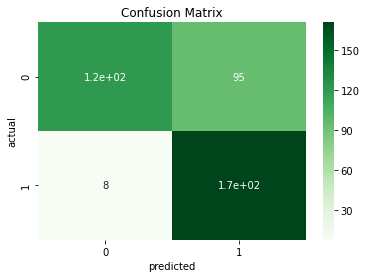

14/14 [==============================] - 37s 3s/step - loss: 0.6330 - accuracy: 0.7494 - precision: 0.6538 - recall: 0.9590


[('loss', 0.6330001950263977),
 ('accuracy', 0.7494145035743713),
 ('precision', 0.6538461446762085),
 ('recall', 0.9589743614196777)]

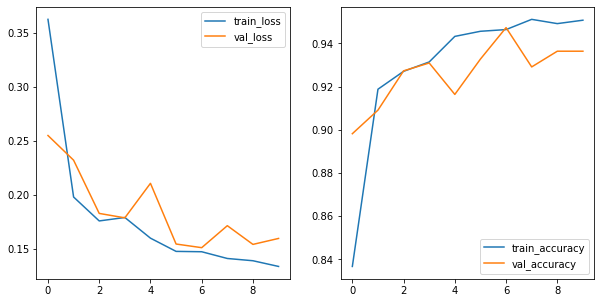

In [126]:
lime_inception_resnet2_preds = lime_inception_resnet2.predict_classes(lime_data_array)
evaluation(lime_class_list, lime_inception_resnet2_preds)

train_loss = lime_inception_resnet2_history.history['loss']
train_acc = lime_inception_resnet2_history.history['accuracy']
val_loss = lime_inception_resnet2_history.history['val_loss']
val_acc = lime_inception_resnet2_history.history['val_accuracy']


fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,5))
sns.lineplot(lime_inception_resnet2_history.epoch, train_loss, ax=ax1, label='train_loss')
sns.lineplot(lime_inception_resnet2_history.epoch, train_acc, ax=ax2, label='train_accuracy')

sns.lineplot(lime_inception_resnet2_history.epoch, val_loss, ax=ax1, label='val_loss')
sns.lineplot(lime_inception_resnet2_history.epoch, val_acc, ax=ax2, label='val_accuracy')

acc = lime_inception_resnet2.evaluate_generator(lime_test_data, steps=len(lime_test_data), verbose=1)
list(zip(lime_inception_resnet2.metrics_names, acc))

In [134]:
models.save_model(lime_inception_resnet2, 'inception_res2', overwrite=True, include_optimizer=True, save_format=None)